In [2]:
from IPython.display import Image
from IPython.display import display, HTML
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from fboost import outlier_iqr, DataPreparator, FeatureBoosterRegressor
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from ffx import FFXRegressor
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


import warnings
warnings.filterwarnings('ignore')

# Set a seed value
seed_value= 0
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

In [3]:
data = pd.read_csv('../data/raw/alldata.csv')
data.columns = ['familia','indice_fam','subposicion_1','subposicion_2','subposicion_3','subposicion_4', 'energia']
mask = (data[['subposicion_1','subposicion_2','subposicion_3','subposicion_4']] == 0).sum(axis=1) > 1
lista_train = data.loc[mask,['subposicion_1','subposicion_2','subposicion_3','subposicion_4','energia']]
lista_test = data.loc[~mask,['subposicion_1','subposicion_2','subposicion_3','subposicion_4','energia']]

In [4]:
# Instantiate the OneHotEncoder
encoder = OneHotEncoder(sparse=False, categories='auto')

X_train = lista_train.drop(['energia'], axis=1)
X_test = lista_test.drop(['energia'], axis=1)

# Fit the encoder and transform the data for both train and test dataframes
encoded_train = encoder.fit_transform(X_train)
encoded_test = encoder.transform(X_test)

# Now, 'encoded_train' and 'encoded_test' are numpy arrays, we can convert them back to dataframes:
X_train_scaled = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(X_train.columns))
X_test_scaled = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(X_test.columns))


y_test = lista_test['energia']
y_train = lista_train['energia']

In [5]:

# assuming df is your DataFrame
df = lista_train.drop(['energia'], axis=1)

# replace zeros with np.nan
df = df.replace(0, np.nan)

# instantiate OneHotEncoder
enc = OneHotEncoder(sparse=False, handle_unknown='ignore')

# apply OneHotEncoder to df
onehot_df = enc.fit_transform(df)

# create H matrix
H = np.zeros(df.shape)

# specify the position of non-zero values in H
for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        if not np.isnan(df.iloc[i, j]):
            H[i, j] = j+1  # or just 1, based on your requirements



In [6]:

X_train_array = np.concatenate((onehot_df, H), axis=1)
X_train_encoded = X_train_array.reshape((X_train_array.shape[0], X_train_array.shape[1], 1))

input_shape_train = (X_train_encoded.shape[1],1)
# assuming onehot_df_encoded and H are your input data and are numpy arrays
# reshape data for Conv1D, the format should be (n_samples, steps, channels)
onehot_df_encoded = onehot_df.reshape((170, 24, 1))
H_encoded = H.reshape((170, 4, 1))

# target data
y_train = np.array(y_train)
input_shape_train

(28, 1)

In [7]:
# assuming df is your DataFrame
df_test = lista_test.drop(['energia'], axis=1)

# replace zeros with np.nan
df_test = df_test.replace(0, np.nan)

# instantiate OneHotEncoder
enc = OneHotEncoder(sparse=False, handle_unknown='ignore')

# apply OneHotEncoder to df
onehot_df_test = enc.fit_transform(df_test)

# create H matrix
H_test = np.zeros(df_test.shape)

# specify the position of non-zero values in H
for i in range(df_test.shape[0]):
    for j in range(df_test.shape[1]):
        if not np.isnan(df_test.iloc[i, j]):
            H_test[i, j] = j+1  # or just 1, based on your requirements


In [8]:
onehot_df_test_encoded = onehot_df_test.reshape((onehot_df_test.shape[0], 24, 1))
H_test_encoded = H_test.reshape((H_test.shape[0], 4, 1))

X_test_array = np.concatenate((onehot_df_test, H_test), axis=1)
X_test_encoded = X_test_array.reshape((X_test_array.shape[0], X_test_array.shape[1], 1))
input_shape_test = (X_test_encoded.shape[1],1)
# target data
y_test = np.array(y_test)
y_test.shape

(1120,)

In [9]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from sklearn.utils import shuffle



def build_model(hp):
    # Input layers
    input_onehot_1d = Input(shape=(24,1))
    input_H_1d = Input(shape=(4,1))

    # Convolutional layers
    conv_onehot_1d = Conv1D(hp.Int('conv_filters_onehot', min_value=32, max_value=256, step=32),
                            hp.Choice('conv_kernel_size_onehot', values=[3,5]), 
                            activation='relu')(input_onehot_1d)
    conv_H_1d = Conv1D(hp.Int('conv_filters_H', min_value=32, max_value=256, step=32),
                       hp.Choice('conv_kernel_size_h', values=[3,5]), 
                       activation='relu')(input_H_1d)

    # Pooling layers
    pool_onehot_1d = MaxPooling1D(pool_size=2)(conv_onehot_1d)
    pool_H_1d = MaxPooling1D(pool_size=2)(conv_H_1d)

    # Flatten layers
    flat_onehot_1d = Flatten()(pool_onehot_1d)
    flat_H_1d = Flatten()(pool_H_1d)

    # Concatenate layer
    concat_layer_1d = concatenate([flat_onehot_1d, flat_H_1d])

    # Dense layers
    dense_1d = Dense(hp.Int('dense_units_1', min_value=512, max_value=1024, step=32), activation='relu')(concat_layer_1d)
    dense_2_1d = Dense(hp.Int('dense_units_2', min_value=256, max_value=512, step=16), activation='relu')(dense_1d)
    dense_3_1d = Dense(hp.Int('dense_units_3', min_value=128, max_value=256, step=16), activation='relu')(dense_2_1d)
    dense_4_1d = Dense(hp.Int('dense_units_4', min_value=16, max_value=128, step=16), activation='relu')(dense_3_1d)
    output_1d = Dense(1, activation='linear')(dense_4_1d)  # assuming this is a regression problem

    # create model with two inputs
    model_1d = Model(inputs=[input_onehot_1d, input_H_1d], outputs=output_1d)

    # compile model
    opt = Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    model_1d.compile(optimizer=opt, loss='logcosh', metrics=['mae'])

    return model_1d


# assuming onehot_df_train, H_train, y_train are your training datasets
input_shape_onehot = (onehot_df_encoded.shape[1], 1)
input_shape_H = (H_encoded.shape[1], 1)

onehot_df_encoded, H_encoded, y_train = shuffle(onehot_df_encoded, H_encoded, y_train)

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=15,
    executions_per_trial=10,
    directory='output',
    project_name='AirQuality',
    overwrite=True)

tuner.search_space_summary()

# Start the search for the best hyperparameters
tuner.search([onehot_df_encoded, H_encoded], y_train,
             epochs=25,
             validation_split=0.2)

# After the tuner is finished, retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# And its hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]






Trial 15 Complete [00h 01m 20s]
val_loss: 0.39861100614070893

Best val_loss So Far: 0.33938426077365874
Total elapsed time: 00h 12m 23s
INFO:tensorflow:Oracle triggered exit


In [10]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history = model.fit([onehot_df_encoded, H_encoded], y_train, epochs=50, validation_split=0.2, verbose=1)

# Let's assume you have a test set


Epoch 1/50
5/5 [==============================] - 2s 119ms/step - loss: 2.1432 - mae: 2.7624 - val_loss: 1.3379 - val_mae: 1.8836
Epoch 2/50
5/5 [==============================] - 0s 73ms/step - loss: 1.2684 - mae: 1.8389 - val_loss: 1.2855 - val_mae: 1.8373
Epoch 3/50
5/5 [==============================] - 0s 75ms/step - loss: 1.2642 - mae: 1.8319 - val_loss: 1.1474 - val_mae: 1.6876
Epoch 4/50
5/5 [==============================] - 0s 77ms/step - loss: 1.0978 - mae: 1.6303 - val_loss: 1.0276 - val_mae: 1.5854
Epoch 5/50
5/5 [==============================] - 0s 71ms/step - loss: 0.9623 - mae: 1.4800 - val_loss: 0.8468 - val_mae: 1.3151
Epoch 6/50
5/5 [==============================] - 0s 72ms/step - loss: 0.8435 - mae: 1.3258 - val_loss: 0.6814 - val_mae: 1.1398
Epoch 7/50
5/5 [==============================] - 0s 71ms/step - loss: 0.7953 - mae: 1.2745 - val_loss: 0.6779 - val_mae: 1.1278
Epoch 8/50
5/5 [==============================] - 0s 78ms/step - loss: 0.7665 - mae: 1.2488 - va

In [11]:
#onehot_df_test_encoded, H_test_encoded = prepare_test_data(onehot_df_test, H_test)  # You need to ensure that your test data is prepared in the same way as your training data

# Now you can make predictions on your test set
predictions = model.predict([onehot_df_test_encoded, H_test_encoded])




35/35 [==============================] - 0s 5ms/step


In [12]:
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('Mean Absolute Error (MAE): ', mae)
print('R-squared Score (R^2): ', r2)

Mean Squared Error (MSE):  15.074957874339127
Root Mean Squared Error (RMSE):  3.882648306805437
Mean Absolute Error (MAE):  2.6404731344051284
R-squared Score (R^2):  0.2690957493702165


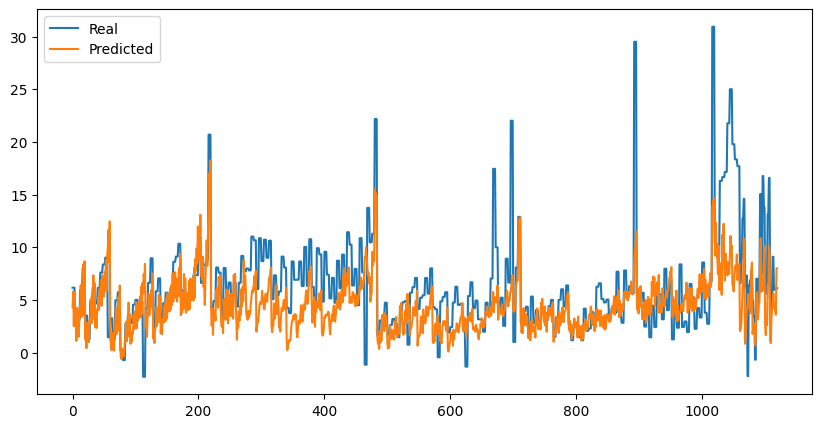

In [13]:
import matplotlib.pyplot as plt

# plot predicted vs real values
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Real')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

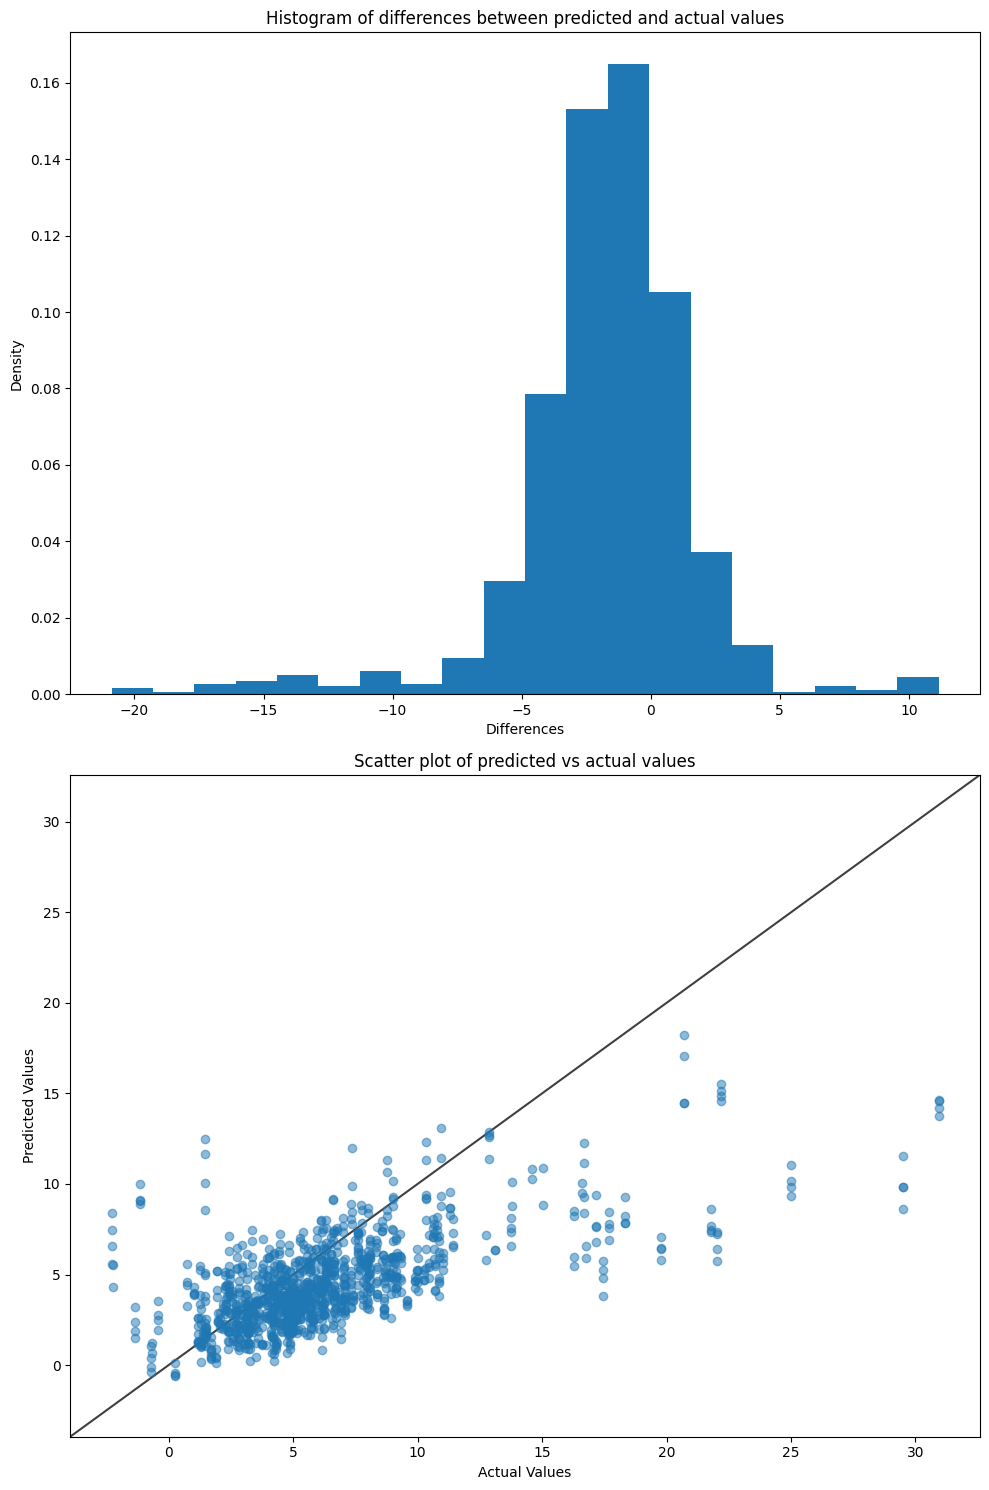

In [14]:
differences = predictions.flatten() - y_test.flatten() # This will give the difference between your predictions and the actual values

#Create a figure with two subplots: a histogram of the differences and a scatter plot of predicted vs real values
fig, axs = plt.subplots(nrows=2, figsize=(10, 15))

#Plot histogram
axs[0].hist(differences, bins=20, density=True)
axs[0].set_title('Histogram of differences between predicted and actual values')
axs[0].set_xlabel('Differences')
axs[0].set_ylabel('Density')

#Plot scatter
axs[1].scatter(y_test, predictions, alpha=0.5)
axs[1].set_title('Scatter plot of predicted vs actual values')
axs[1].set_xlabel('Actual Values')
axs[1].set_ylabel('Predicted Values')

#Draw a diagonal line on the scatterplot
lims = [np.min([axs[1].get_xlim(), axs[1].get_ylim()]), # min of both axes
np.max([axs[1].get_xlim(), axs[1].get_ylim()])] # max of both axes
axs[1].plot(lims, lims, 'k-', alpha=0.75, zorder=0)
axs[1].set_xlim(lims)
axs[1].set_ylim(lims)

plt.tight_layout()
plt.show()